In [3]:
##Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/activation"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# Fetching the device that will be used throughout this notebook
device = torch.device(
    "cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)


Using device cpu


In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config",      "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

# Common activation functions
As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the torch.nn package (see the documentation for an overview). However, we’ll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit:

In [6]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name":self.name}

Every activation function will be an nn.Module so that we can integrate them nicely in a network. We will use the config dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the “oldest” activation functions that are still commonly used for various tasks: sigmoid and tanh. Both the sigmoid and tanh activation can be also found as PyTorch functions (torch.sigmoid, torch.tanh) or as modules (nn.Sigmoid, nn.Tanh). Here, we implement them by hand:

In [7]:
class Sigmoid(ActivationFunction):
    
    def forward(self,x):
        return 1 / (1 + torch.exp(-x))

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

Another popular activation function that has allowed the training of deeper networks, is the Rectified Linear Unit (ReLU). Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values. Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish. LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input. Similarly, ELU replaces the negative part with an exponential decay. The third, most recently proposed activation function is Swish, which is actually the result of a large experiment with the purpose of finding the “optimal” activation function. Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient). This has been shown to prevent dead neurons as in standard ReLU activation, especially for deep networks.

In [8]:
class ReLU(ActivationFunction):

    def forward(self,x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config['alpha'] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config['alpha']*x)

class ELU(ActivationFunction):
    
    def forward(self, x):
        return torch.where(x>0,x,torch.exp(x)-1)

class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [9]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

## Visualizing activation functions
To get an idea of what each activation function actually does, we will visualize them in the following. Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network. PyTorch allows us to compute the gradients simply by calling the backward function:

In [10]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_(
    )  # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()  # Summing results in an equal gradient flow to each element in x
    return x.grad  # Accessing the gradients of x by "x.grad"

In [11]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x,y and gradients back to cpu
    x, y, y_grads = x.numpy(), y.numpy(), y_grads.numpy()
    # Plotting
    ax.plot(x,y, linewidth=2, label='ActFn')
    ax.plot(x, y_grads, linewidth=2, label='Gradient')
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

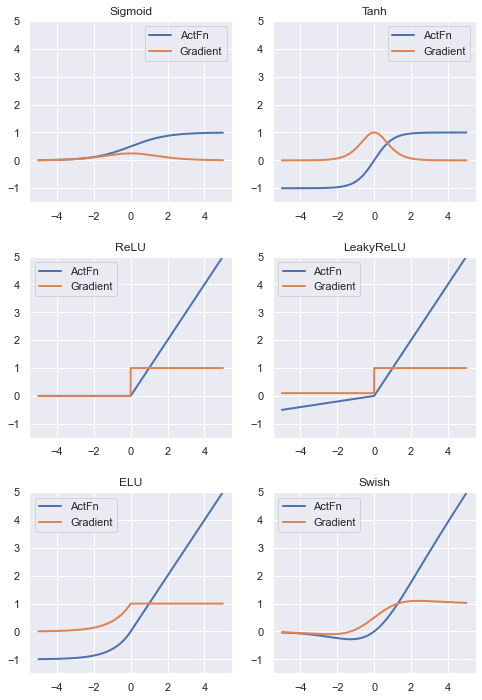

In [13]:
# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
# Range on which we want to visualize the activation functions
x = torch.linspace(-5, 5, 1000)
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, 2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()